<a href="https://colab.research.google.com/github/realtechsupport/cocktail/blob/main/sandbox/notebooks/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
from tensorflow import keras

model = keras.models.load_model("/content/gdrive/MyDrive/exp/tf_record_model.hdf5")

In [4]:
import os
!pip install rasterio
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sys, os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 56.9 MB/s eta 0:00:00


In [5]:
# Specify the folder path where your images are located
test_image_path = '/content/gdrive/MyDrive/exp/other images/test_folder/area2_0619_2023_8bands_composite.tif'


#Specify the path where your clipping mask are located
geojson_datapath = '/content/gdrive/MyDrive/exp/label/newextent_1123.geojson'

In [6]:
def clip_tiff(tiff, geojson = geojson_datapath):

    with open(geojson) as clip_geojson:
        clip_geojson = gpd.read_file(clip_geojson)
        clip_geometry = clip_geojson.geometry.values[0]
        clip_geojson = mapping(clip_geometry)
        #print(clip_geojson)

    with rasterio.open(tiff) as src:
        #print("input image data before processing", src.meta)

        # Perform the clip
        clip_image, clip_transform = mask(src, [clip_geojson], crop=True)
        #print("shape of clipped_image:", clip_image.shape)
        #print("extent of clipped image:", clip_transform)
        #clip_meta = src.meta.copy()

    # clip_meta.update({"driver": "GTiff",
    #                   "height": clip_image.shape[1],
    #                   "width": clip_image.shape[2],
    #                   "transform": clip_transform})
    return clip_image



def predict_input(image):
    # image = clip_tiff(image)
    ## resizing and process input funciton condensed into one.
    tensor_image = tf.convert_to_tensor(image)
    tensor_image = tf.transpose(tensor_image, perm=[1, 2, 0])
    return tensor_image

def bandwise_normalize(input_tensor, epsilon=1e-8):
    # Convert the input_tensor to a float32 type
    input_tensor = tf.cast(input_tensor, tf.float32)

    # Calculate the minimum and maximum values along the channel axis
    min_val = tf.reduce_min(input_tensor, axis=2, keepdims=True)
    max_val = tf.reduce_max(input_tensor, axis=2, keepdims=True)

    # Check for potential numerical instability
    denom = max_val - min_val
    denom = tf.where(tf.abs(denom) < epsilon, epsilon, denom)

    # Normalize the tensor band-wise to the range [0, 1]
    normalized_tensor = (input_tensor - min_val) / denom

    return normalized_tensor

def pad_to_multiple(image, TILE_HT, TILE_WD):
    # Get the current dimensions
    height, width, channels = image.shape

    # Calculate the target dimensions
    target_height = tf.cast(tf.math.ceil(height / TILE_HT) * TILE_HT, tf.int32)
    target_width = tf.cast(tf.math.ceil(width / TILE_WD) * TILE_WD, tf.int32)

    # Calculate the amount of padding
    pad_height = target_height - height
    pad_width = target_width - width

    # Pad the image
    padded_image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)

    return padded_image

def tile_image(fullimg, CHANNELS=1, TILE_HT=128, TILE_WD=128):
    fullimg = pad_to_multiple(fullimg, TILE_HT, TILE_WD)
    images = tf.expand_dims(fullimg, axis=0)
    tiles = tf.image.extract_patches(
        images=images,
        sizes=[1, TILE_HT, TILE_WD, 1],
        strides=[1, TILE_HT, TILE_WD, 1],
        rates=[1, 1, 1, 1],
        padding='VALID')
    print(tiles.shape)

    tiles = tf.squeeze(tiles, axis=0)
    nrows = tiles.shape[0]
    ncols = tiles.shape[1]
    print(tiles.shape)
    all_tiles = tf.reshape(tiles, [nrows* ncols, TILE_HT, TILE_WD, CHANNELS])
    ordered_tiles = tf.reshape(tiles, [nrows, ncols, TILE_HT, TILE_WD, CHANNELS])
    print(all_tiles.shape)
    print(ordered_tiles.shape)
    return ordered_tiles, all_tiles, fullimg.shape

In [7]:
image = clip_tiff(test_image_path)

new_image = predict_input(image)

normalized_image = bandwise_normalize(new_image)

display_patches,inference_patches,dims = tile_image(normalized_image,8,256,256)

(1, 15, 18, 524288)
(15, 18, 524288)
(270, 256, 256, 8)
(15, 18, 256, 256, 8)


In [10]:
dims

TensorShape([3840, 4608, 8])

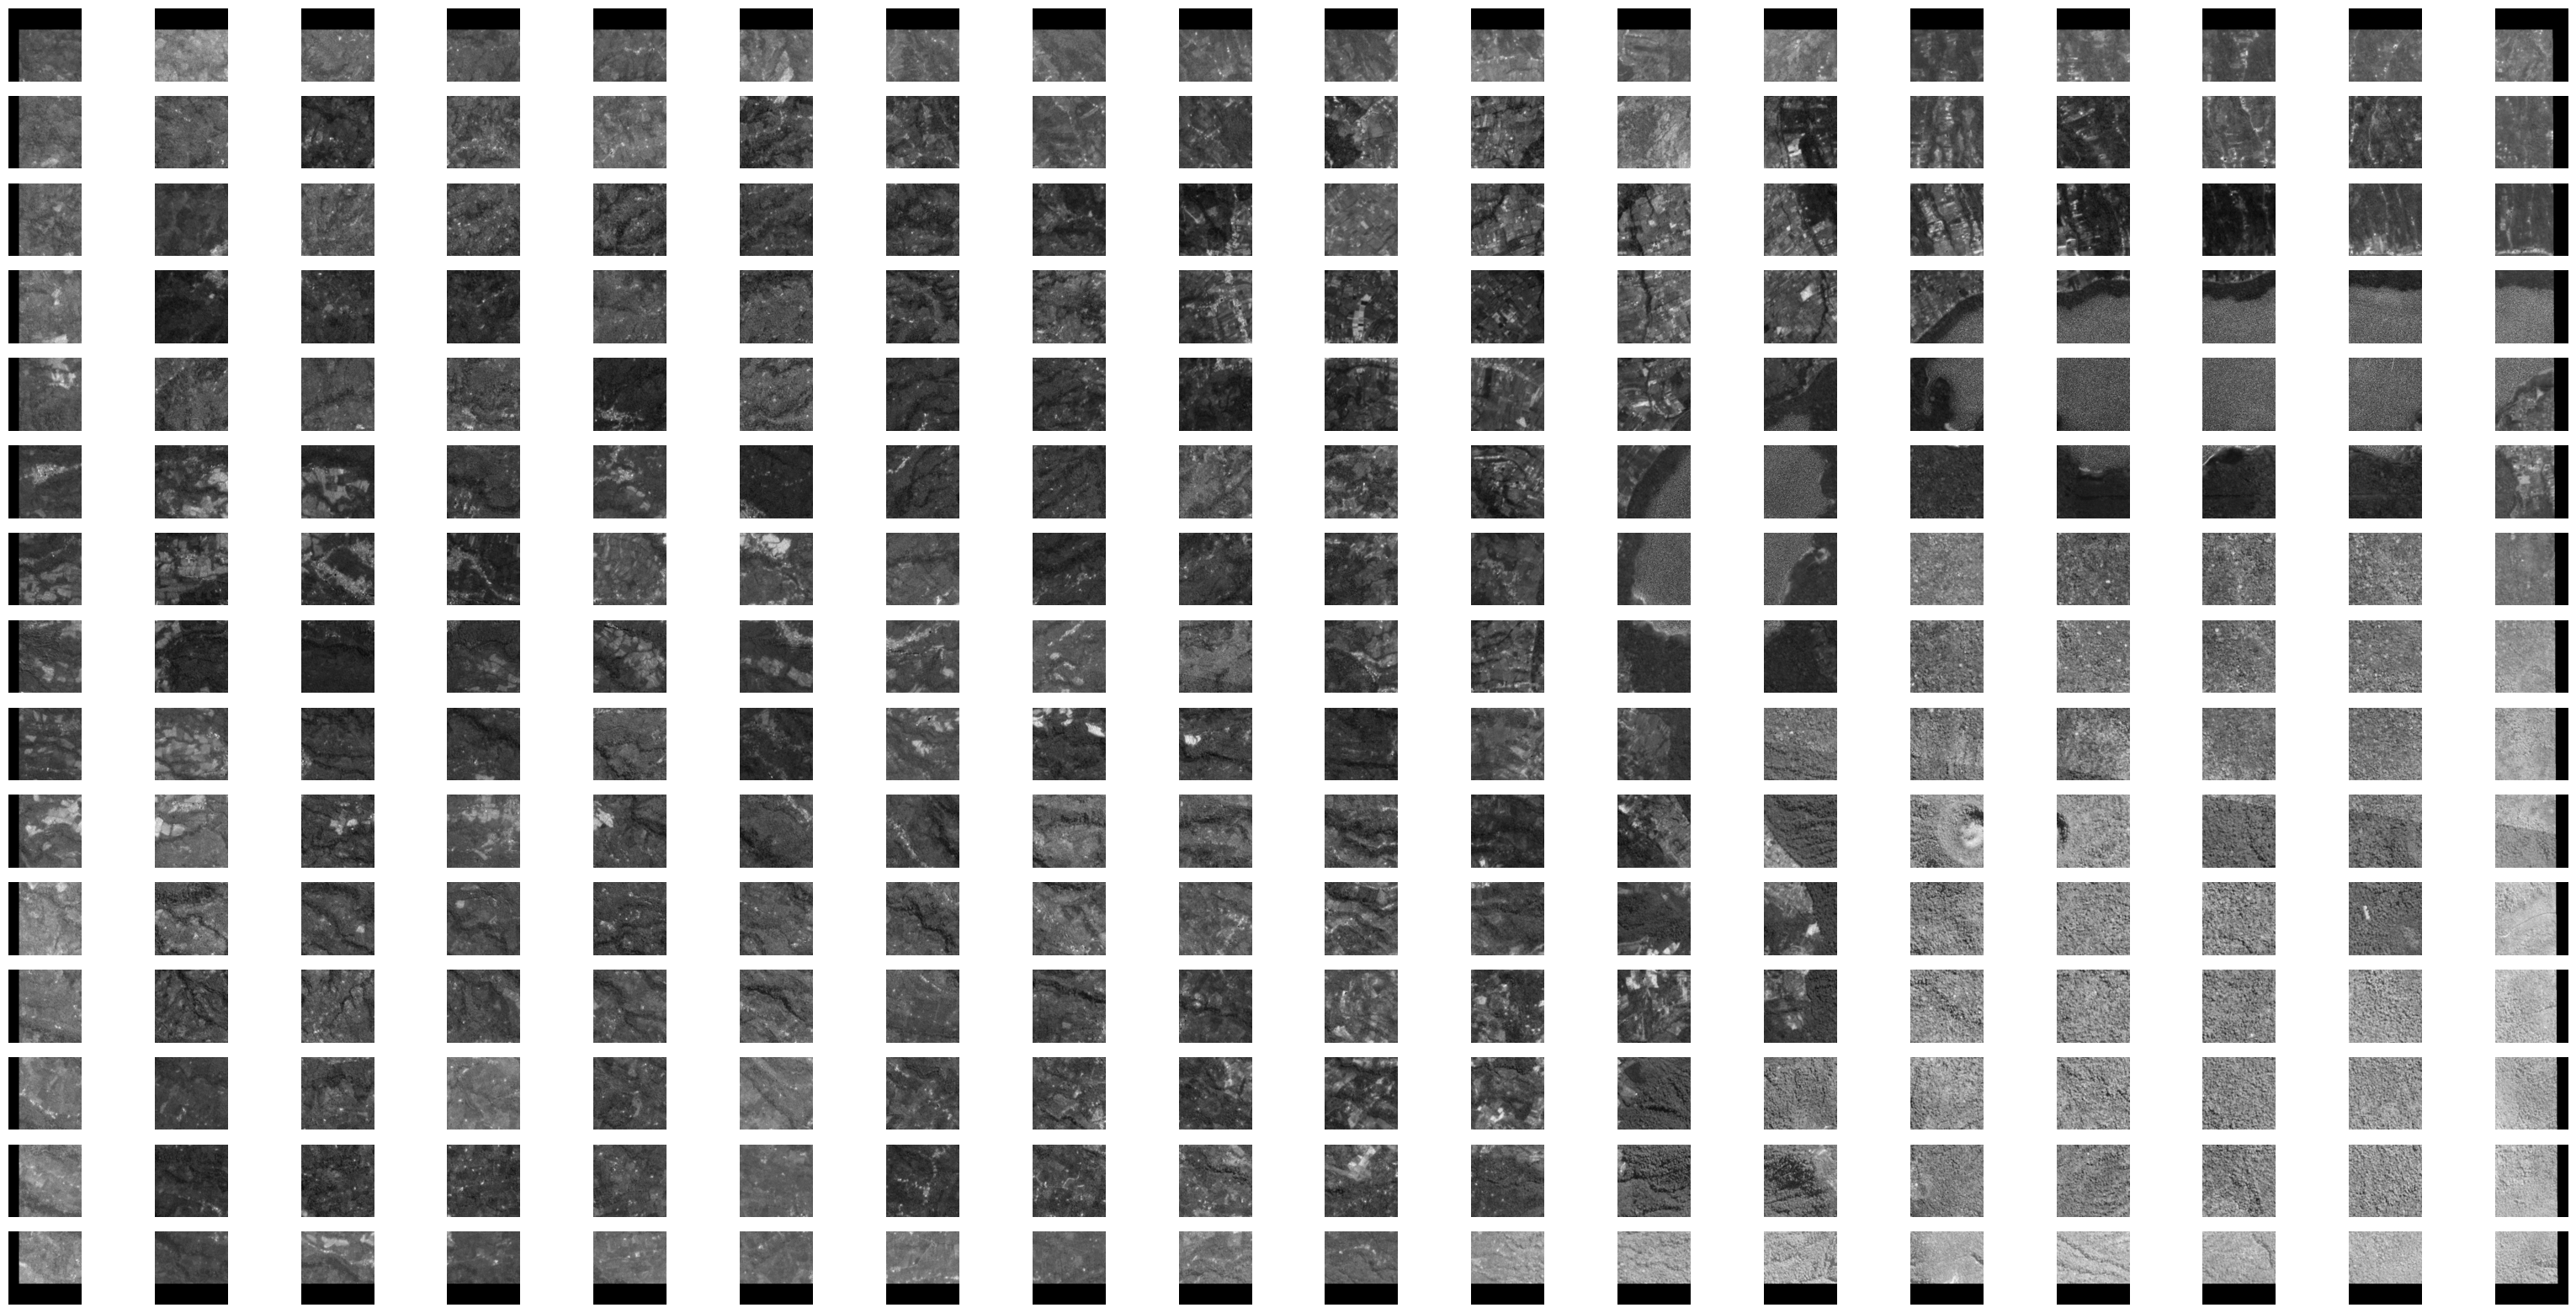

In [11]:
tiles = display_patches
nrows = tiles.shape[0]
ncols = tiles.shape[1]
f, ax = plt.subplots(nrows, ncols, figsize=(40,20))
for rowno in range(nrows):
    for colno in range(ncols):
        img = tiles[rowno][colno][:, :, -2]
        ax[rowno, colno].imshow( tiles[rowno][colno][:, :, -2].numpy(),cmap='gray'  );
        ax[rowno, colno].axis('off')

In [12]:
predictions = model.predict(inference_patches)

9/9 [==============================] - 36s 4s/step


In [13]:

# Assuming logits is your input tensor of shape (270, 256, 256, 23)
logits = predictions

# Set values of class 0 to a very large negative number
mask = tf.one_hot(0, depth=23, on_value=float('-inf'), off_value=0, dtype=tf.float32)
logits_with_mask = logits + mask

# Perform argmax along the last axis (axis=-1)
argmax_result = tf.argmax(logits_with_mask, axis=-1)

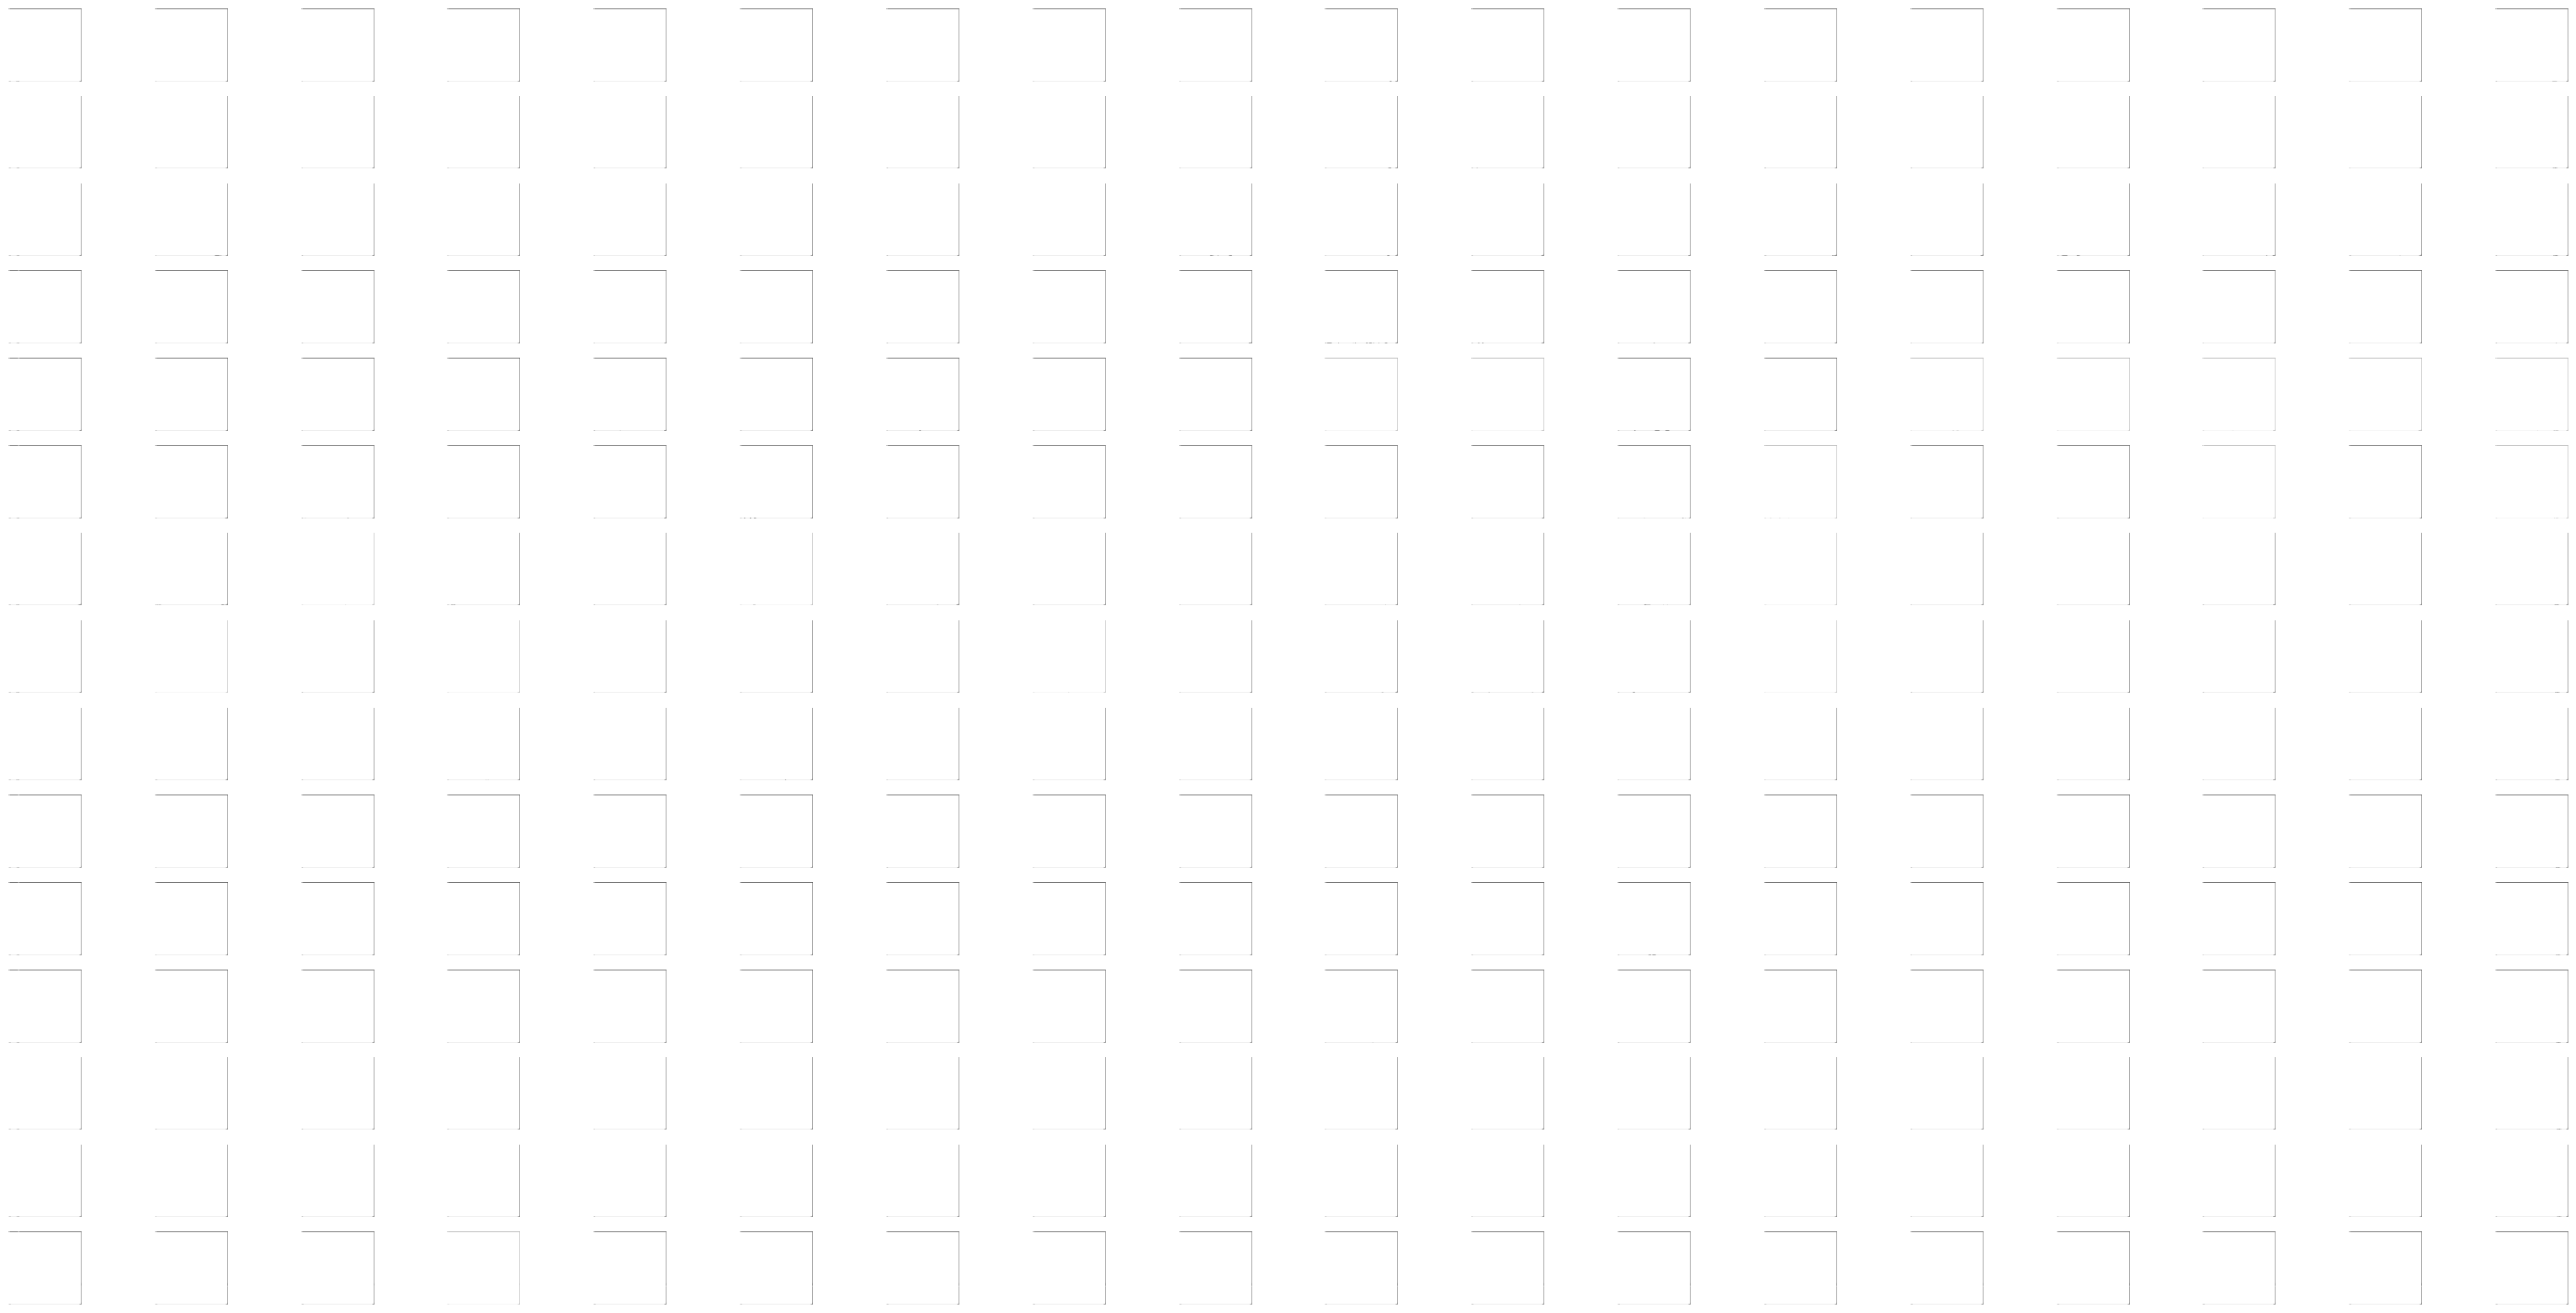

In [20]:
tiles = display_patches

nrows = tiles.shape[0]
ncols = tiles.shape[1]

segmentation_patches = tf.reshape(argmax_result, [nrows, ncols, 256, 256])
f, ax = plt.subplots(nrows, ncols, figsize=(40,20))

segmented_patches = []
for rowno in range(nrows):
    for colno in range(ncols):
        img = segmentation_patches[rowno][colno]
        segmented_patches.append(img)
        ax[rowno, colno].imshow( segmentation_patches[rowno][colno].numpy(),cmap='gray');
        ax[rowno, colno].axis('off')

In [16]:
height= dims[0]
width = dims[1]
patch_size = 256
stitched_array = np.zeros((height,width))
patch_idx = 0
for i in range(0, height, patch_size):
    for j in range(0, width, patch_size):
        patch = segmented_patches[patch_idx]
        stitched_array[i:i+patch_size, j:j+patch_size] = patch
        patch_idx += 1

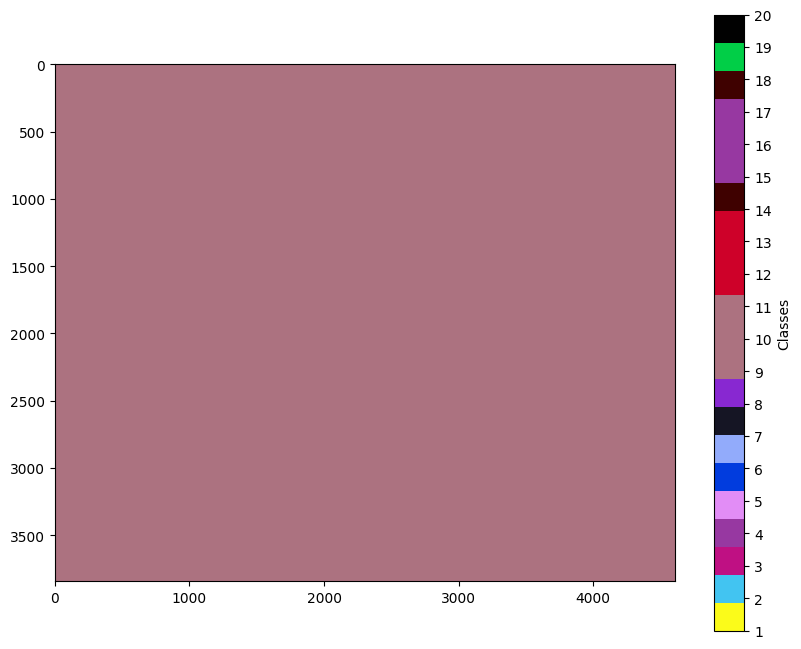

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define the class-color mapping
class_colors = {
    1: ( 5, 5, 230),
    2: (190, 60, 15),
    3: (65, 240, 125),
    4: (105, 200, 95),
    5: ( 30, 115, 10),
    6: ( 255, 196, 34),
    7: (110, 85, 5),
    8: ( 235, 235, 220),
    9: (120, 216, 47),
    10: ( 84, 142, 128),
    11: ( 84, 142, 128),
    12: ( 84, 142, 128),
    13: ( 50, 255, 215),
    14: ( 50, 255, 215),
    15: ( 50, 255, 215),
    16: ( 193, 255, 0),
    17: ( 105, 200, 95),
    18: (105, 200, 95),
    19: ( 105, 200, 95),
    20: (193, 255, 0),
    21: ( 255, 50, 185),
    22: (255, 255, 255),
}

# Create a colormap using the class-color mapping
colors = [class_colors[i] for i in range(1, 23)]
cmap = ListedColormap(colors)

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 8))


# Plot the segmentation mask using the custom colormap
image = ax.imshow(stitched_array, cmap=cmap, vmin=1, vmax=20)

# Add a colorbar to show the class-color mapping
cbar = plt.colorbar(image, ax=ax, ticks=list(class_colors.keys()))
cbar.set_label('Classes')

# Show the plot
plt.show()
plt.savefig('/content/segmentation_mask.png')